## LSTM Applied to Energy Production

This template is based on the RNN exercise in Udemy PyTorch course by PIERIAN DATA. Data is from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N


<img src="https://pic4.zhimg.com/80/v2-ebf8cd2faa564d9d80a958dcf25e6b3b_1440w.jpg"/>

### Perform standard imports, load and plot the dataset


In [5]:
pwd

'/Users/Siyue/Projects/Tutorials/PyTorch/RNN'

In [6]:
# RUN THIS CELL
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('./Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


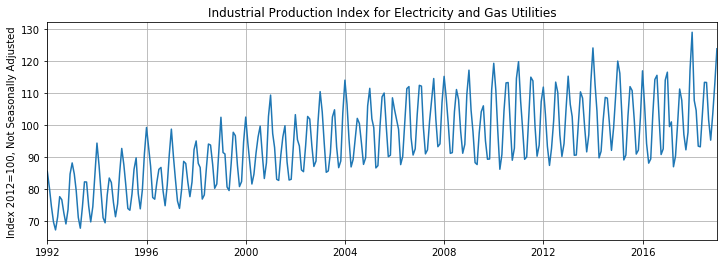

In [7]:
# RUN THIS CELL
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

### Prepare the data
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

### 1. Divide the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [8]:
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


### 2. Normalize the training set
Feature scale the training set to fit within the range [-1,1].

In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1,1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 85.556
First item, scaled:  [-0.4091274]


### 3. Prepare data for LSTM
Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [17]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

train_data = input_data(train_norm,window_size)
print(f'Train_data: {len(train_data)} tuples')
print(train_data[0])

Train_data: 301 tuples
(tensor([-0.4091, -0.5761, -0.7607, -0.9201, -1.0000, -0.8686, -0.6636, -0.6944,
        -0.8313, -0.9396, -0.7939, -0.4343]), tensor([-0.3223]))


### 4. Define the model
Design a model that has a (1,64) LSTM layer and a (64,1) fully-connected linear layer. Be sure to initialize $h_0$ and $c_0$, and return only the last predicted value.

In [20]:
class LSTMnetwork(nn.Module):
    
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))
        
    def forward(self, seq):
        lstm_out, hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

### Instantiate the model, define loss and optimization functions

In [22]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [23]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   256
 16384
   256
   256
    64
     1
______
 17217


## Train the model

In [24]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.73148888
Epoch:  2 Loss: 0.32154250
Epoch:  3 Loss: 0.24067906
Epoch:  4 Loss: 0.22756192
Epoch:  5 Loss: 0.21155117
Epoch:  6 Loss: 0.19909392
Epoch:  7 Loss: 0.19070974
Epoch:  8 Loss: 0.18484065
Epoch:  9 Loss: 0.17965080
Epoch: 10 Loss: 0.17444251
Epoch: 11 Loss: 0.16900931
Epoch: 12 Loss: 0.16327691
Epoch: 13 Loss: 0.15734859
Epoch: 14 Loss: 0.15141533
Epoch: 15 Loss: 0.14568549
Epoch: 16 Loss: 0.14033332
Epoch: 17 Loss: 0.13546899
Epoch: 18 Loss: 0.13113394
Epoch: 19 Loss: 0.12731297
Epoch: 20 Loss: 0.12395491
Epoch: 21 Loss: 0.12099446
Epoch: 22 Loss: 0.11836994
Epoch: 23 Loss: 0.11603168
Epoch: 24 Loss: 0.11394265
Epoch: 25 Loss: 0.11207756
Epoch: 26 Loss: 0.11042286
Epoch: 27 Loss: 0.10897986
Epoch: 28 Loss: 0.10776711
Epoch: 29 Loss: 0.10681627
Epoch: 30 Loss: 0.10615853
Epoch: 31 Loss: 0.10583407
Epoch: 32 Loss: 0.10595255
Epoch: 33 Loss: 0.10659042
Epoch: 34 Loss: 0.10754268
Epoch: 35 Loss: 0.10849246
Epoch: 36 Loss: 0.10928920
Epoch: 37 Loss: 0.10990778
E

## Run predictions and compare to known test set

In [25]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

preds[window_size:]

[0.42133697867393494,
 0.2162609100341797,
 -0.2843930125236511,
 -0.2054521143436432,
 0.2561052143573761,
 0.38206595182418823,
 0.13555750250816345,
 -0.06118144094944,
 -0.3135444223880768,
 -0.13242653012275696,
 0.21429625153541565,
 0.6428248882293701]

## Inverse transform the predicted values
Rescale the predicted values up to the original test set range.

In [26]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[111.10482148],
       [104.79575877],
       [ 89.39339117],
       [ 91.82196843],
       [106.02154887],
       [109.89666797],
       [102.31295879],
       [ 96.26038356],
       [ 88.49656262],
       [ 94.06856401],
       [104.73531703],
       [117.91878627]])

In [29]:
df[-future:]

,IPG2211A2N
DATE,
2018-02-01,107.6711
2018-03-01,104.5716
2018-04-01,93.4491
2018-05-01,93.2405
2018-06-01,103.3083
2018-07-01,113.3178
2018-08-01,113.2758
2018-09-01,101.5656
2018-10-01,95.3203


### Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [30]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

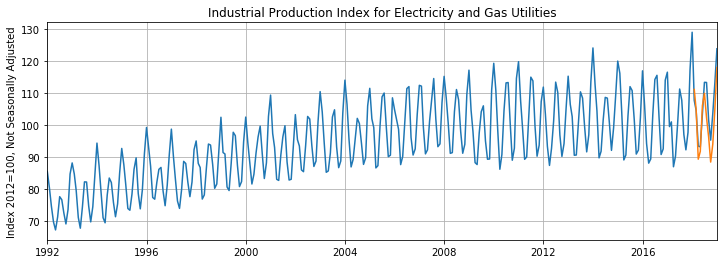

In [40]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df.iloc[:,0])
plt.plot(x,true_predictions)
plt.show()

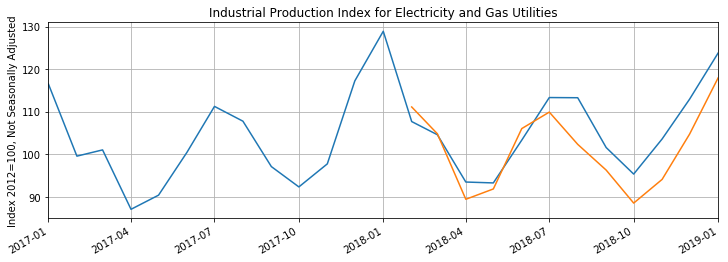

In [42]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df.iloc[:,0]['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

For more information on x-axis date formatting in matplotlib, check out <a href='https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.autofmt_xdate'><tt><strong>matplotlib.figure.Figure.autofmt_xdate</strong></tt></a> and <a href='https://matplotlib.org/api/dates_api.html#matplotlib.dates.DateFormatter'><tt><strong>matplotlib.dates.DateFormatter</strong></tt></a>

## Forecast into an unknown future
Lastly train the model using the entire dataset, and predict 12 steps into the future.

In [43]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00047547
Epoch:  2 Loss: 0.00078331
Epoch:  3 Loss: 0.00032391
Epoch:  4 Loss: 0.00003545
Epoch:  5 Loss: 0.00005754
Epoch:  6 Loss: 0.00034472
Epoch:  7 Loss: 0.00063708
Epoch:  8 Loss: 0.00089555
Epoch:  9 Loss: 0.00104277
Epoch: 10 Loss: 0.00112235
Epoch: 11 Loss: 0.00117627
Epoch: 12 Loss: 0.00119221
Epoch: 13 Loss: 0.00123099
Epoch: 14 Loss: 0.00134312
Epoch: 15 Loss: 0.00157337
Epoch: 16 Loss: 0.00185089
Epoch: 17 Loss: 0.00191563
Epoch: 18 Loss: 0.00174617
Epoch: 19 Loss: 0.00023680
Epoch: 20 Loss: 0.00010180
Epoch: 21 Loss: 0.00051462
Epoch: 22 Loss: 0.00294661
Epoch: 23 Loss: 0.00049081
Epoch: 24 Loss: 0.00051542
Epoch: 25 Loss: 0.00043991
Epoch: 26 Loss: 0.00011575
Epoch: 27 Loss: 0.00008769
Epoch: 28 Loss: 0.00015526
Epoch: 29 Loss: 0.00002272
Epoch: 30 Loss: 0.00019990
Epoch: 31 Loss: 0.00071239
Epoch: 32 Loss: 0.00005685
Epoch: 33 Loss: 0.00003308
Epoch: 34 Loss: 0.00001260
Epoch: 35 Loss: 0.00005475
Epoch: 36 Loss: 0.00443742
Epoch: 37 Loss: 0.00002803
E

### Predict future values, plot the result

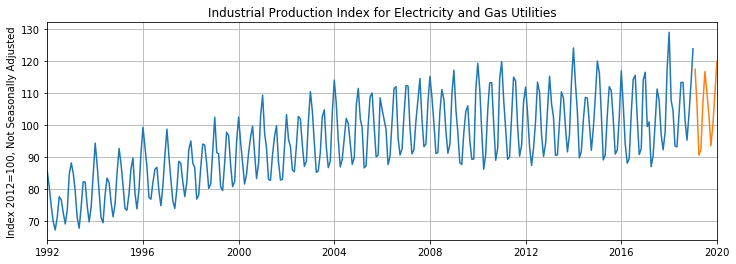

In [44]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df.iloc[:,0])
plt.plot(x,true_predictions[window_size:])
plt.show()

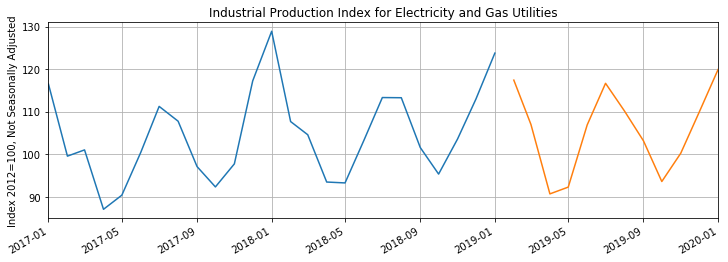

In [46]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df.iloc[:,0]['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()